In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
import tensorflow as tf

## Download and load custom op extension

In [2]:
import urllib.request
response = urllib.request.urlopen("https://raw.githubusercontent.com/yaroslavvb/memory_probe_ops/master/linux.memory_probe_ops.so")
open("memory_probe_ops.so", "wb").write(response.read())
memory_probe_ops = tf.load_op_library("./memory_probe_ops.so")

## Check memory before and after initializing variable

In [3]:
sess = tf.InteractiveSession()
with tf.device("/gpu:0"):
    probe_op = memory_probe_ops.bytes_in_use()
    max_op = memory_probe_ops.bytes_limit()
    mbs = 42
    n = mbs*250000
    inputs = tf.random_uniform((n,))

    var = tf.Variable(inputs)
    probe_op = memory_probe_ops.bytes_in_use()
    max_op = memory_probe_ops.bytes_limit()
    print("Before init %10d out of %10d bytes" % tuple(sess.run([probe_op, max_op])))
    sess.run(var.initializer)
    print("After  init %10d out of %10d bytes" % tuple(sess.run([probe_op, max_op])))

Before init       1280 out of 12051264308 bytes
After  init   67110656 out of 12051264308 bytes


## Probe memory on multiple GPUs 

Check that gpu:1 and gpu:2 memory are unaffected by variable initialized gpu:0 in previous cell

In [4]:
with tf.device("/gpu:1"):
    probe_op_gpu1 = memory_probe_ops.bytes_in_use()
with tf.device("/gpu:2"):
    probe_op_gpu2 = memory_probe_ops.bytes_in_use()
print("gpu:1 bytes %d, gpu:2 bytes %d" % tuple(sess.run([probe_op_gpu1, probe_op_gpu2])))

gpu:1 bytes 1280, gpu:2 bytes 1280


## Probe memory within single step

You can probe memory during step execution by using control dependencies to control when probe gets executed. Here's an example of tracing a computation that needs up to 100MB for the first half of computation, and then 50MB for the rest

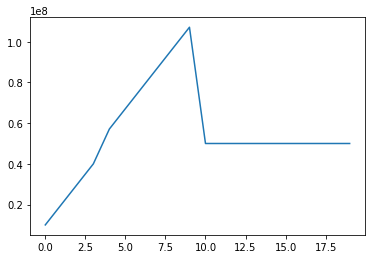

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# makes chain of ops
def make_chain(length, mbs_per_node):
    n = mbs_per_node*250000
    node0 = tf.random_uniform((n,))
    node = node0
    leaf = node0
    probes = []
    nodes = [node]
    for i in range(length):
        with tf.control_dependencies([node, leaf]):
            probe = memory_probe_ops.bytes_in_use()
        probes.append(probe)
        with tf.control_dependencies([probe]):
            leaf = tf.random_uniform((n,))
            if i < length//2:
                node = tf.add_n(nodes+[leaf])
            else:
                node = tf.add_n(nodes[-length//4:]+[leaf])
        nodes.append(node)
    return nodes, probes

tf.reset_default_graph()
sess = tf.InteractiveSession()
with tf.device("/gpu:0"):
    nodes, probes = make_chain(20, 10)
initial_memory = sess.run(memory_probe_ops.bytes_in_use())
_, probes0 = sess.run([nodes[-1], probes])
plt.plot(np.array(probes0)-initial_memory)